In [40]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from river.decomposition import OnlineDMD
from river.decomposition.osvd import _sort_svd
from river.preprocessing import Hankelizer
from river.utils import Rolling
from tqdm import tqdm

sys.path.append("../")
from functions.chdsubid import SubIDChangeDetector
from functions.plot import plot_chd
from functions.preprocessing import hankel

Rolling.learn_one = Rolling.update  # type: ignore

In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Snapshots processed: 100%|██████████| 10000/10000 [00:33<00:00, 300.65it/s]


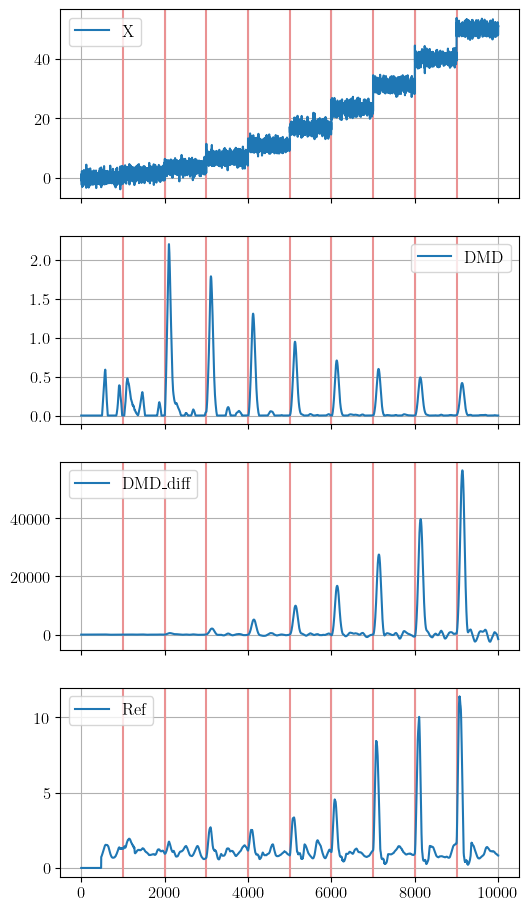

In [42]:
# [donotremove]
# Load reference scores in long list format
scores_ref_ = np.recfromtxt("data/synthetic-steps/scores.txt").reshape(
    -1, 10000
)

# Initialize parameters
# Kawahara 2007 parameters
window_size = 300
hn = 80
ref_size = 100
test_size = 100
r = 2

# Iterate over all example datasets
n_datasets = 1
for n_d in range(n_datasets):
    # Read data
    X = np.recfromtxt(f"data/synthetic-steps/y{n_d}.txt")

    # Take batches from scores_ref list based on length of X
    scores_ref = scores_ref_[n_d, :]

    hankelizer = Hankelizer(hn)

    # Initialize Transformer
    # Using Rolling requires scaler to be added
    odmd = Rolling(
        OnlineDMD(
            r=r,
            initialize=window_size,
            w=1.0,
            exponential_weighting=False,
            seed=42,
        ),
        window_size + 1,
    )
    # Initialize Change-Point Detector
    subid_dmd = SubIDChangeDetector(
        odmd,
        ref_size=ref_size,
        test_size=test_size,
        grace_period=window_size + test_size + 1,
    )

    # Build pipeline
    pipeline_dmd = hankelizer | subid_dmd

    hankelizer_ = Hankelizer(hn)
    # Prepare arrays for storing results
    scores_dmd = np.zeros(X.shape[0], dtype=float)
    scores_dmd_diff = np.zeros(X.shape[0], dtype=complex)
    dist = np.zeros((X.shape[0], 2), dtype=complex)
    modes = np.empty((X.shape[0], hn, r), dtype=float)
    mean_modes = np.empty(X.shape[0], dtype=float)
    svs = np.zeros((X.shape[0], r, r), dtype=float)
    us_dmd = np.zeros((X.shape[0], hn, r), dtype=float)
    As = np.zeros((X.shape[0], r, r), dtype=float)

    # Run pipeline
    for i, (x) in tqdm(
        enumerate(X),
        total=len(X),
        mininterval=1.0,
        desc="Snapshots processed",
    ):
        scores_dmd[i] = pipeline_dmd.score_one({"x": x})
        dist[i, :] = subid_dmd.distances
        scores_dmd_diff[i] = dist[i, 1] - dist[i, 0]

        pipeline_dmd.learn_one({"x": x})

        if subid_dmd.n_seen > window_size + test_size:
            modes[i, :, :] = odmd.modes.real
            mean_modes[i] = modes[i, :, :].mean()
            svs[i, :, :] = odmd._svd._S
            us_dmd[i, :, :] = odmd._svd._U
            As[i, :, :] = odmd.A

    fig, axs = plot_chd(
        [
            X,
            scores_dmd.real,
            scores_dmd_diff.real,
            scores_ref.real,
        ],
        list(range(1000, X.shape[0], 1000)),
        ["X", "DMD", "DMD_diff", "Ref"],
    )

    fig_name = (
        f"results/.synthetic-steps/y{n_d}-chd_r{r}_{ref_size}_{test_size}-"
        f"{f'roll_{odmd.window_size}' if isinstance(odmd, Rolling) else 'noroll'}-"
        f"dmd_w{odmd.w}-h{hn}.pdf"
    )

    os.makedirs(os.path.dirname(fig_name), exist_ok=True)
    fig.savefig(fig_name)

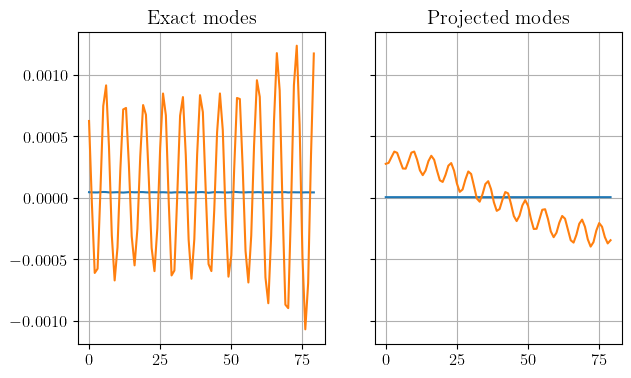

In [43]:
# [donotremove]
_, axs = plt.subplots(1, 2, sharey=True)
axs[0].set_title("Exact modes")
axs[0].plot(
    odmd._Y.T @ odmd._svd._Vt.T @ np.diag(1 / odmd._svd._S) @ odmd.eig[1]
)
axs[1].set_title("Projected modes")
axs[1].plot(odmd._svd._U @ np.diag(1 / odmd._svd._S) @ odmd.eig[1])

In [44]:
hX = hankel(X, hn)

svs_batch = np.zeros((hX.shape[0], 2), dtype=float)
us_batch = np.zeros((hX.shape[0], 80, 2), dtype=float)
for i in range(0, hX.shape[0], 1000):
    if len(hX.shape) > 1 and r < hX.shape[1]:
        u, s, v = sp.sparse.linalg.svds(hX[0 : i + 1000].T, k=r)
        u, s, v = _sort_svd(u, s, v)
    else:
        u, s, v = np.linalg.svd(hX[0 : i + 1000], full_matrices=False)
    svs_batch[i : i + 1000, :] = s
    us_batch[i : i + 1000, :] = u

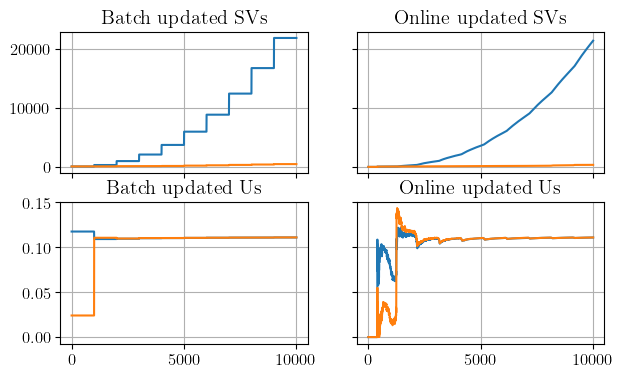

In [45]:
# [donotremove]
_, axs = plt.subplots(2, 2, sharey="row", sharex="col")
axs = axs.flatten()
axs[0].set_title("Batch updated SVs")
axs[0].plot(svs_batch)
axs[1].set_title("Online updated SVs")
axs[1].plot(np.array(svs[:, 0, :]))
axs[2].set_title("Batch updated Us")
axs[2].plot(np.abs(us_batch[:, :2, 0]))
axs[3].set_title("Online updated Us")
axs[3].plot(np.abs(us_dmd[:, :2, 0]))